# Identifiability Test: it is difficult to distinguish feature attributions that are from different model reasoning

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import smerf
from smerf.models import *
from smerf.textbox_data import *
from smerf.eval import *
import smerf.explanations as saliency

CACHE_DIR = '../outputs/cache'
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
PLOT_DIR = '../outputs/plots'
if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)
    
exp_no = 1.11
print('EXP_NO = %f'%exp_no)
data_name = os.path.join('../data/', 'textbox_%0.2f.npz'%exp_no)

tmp = np.load(open(data_name, 'rb'), allow_pickle=True)
x_train = tmp['x_train']
x_test = tmp['x_test']
y_train = tmp['y_train']
y_test = tmp['y_test']

methods_name =  os.path.join(CACHE_DIR, 'methods_%0.2f.pkl'%exp_no)
methods = pickle.load(open(methods_name, 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
EXP_NO = 1.110000


In [4]:
def id_test(x_test, y_test, x_train, load=True):
    mr_list = [1.11, 2.11, 1.20, 3.71, 3.72, 3.73, 3.74]
    fname = os.path.join(CACHE_DIR, 'id_test_results.pkl')
    if os.path.exists(fname) and load:
        dd = pickle.load(open(fname, 'rb'))
    else:
        dd = []
        for exp_no in mr_list:
            print(exp_no)
            if os.path.exists(os.path.join(CACHE_DIR, 'id_test_results_%0.2f,pkl'%(exp_no))):
                result = pickle.load(open(os.path.join(CACHE_DIR, 'id_test_results_%0.2f,pkl'%(exp_no)), 'rb'))
            else:
                model_name = 'w%0.2f.pt'%exp_no
                if exp_no >= 3.5 or exp_no == 1.2:
                    model_obj = TextColorCNN_adv(lr=0.0001, 
                                                model_name=model_name, 
                                                max_epoch=10, 
                                                output_dir=CACHE_DIR)
                else:
                    model_obj = TextColorCNN(lr=0.0001, 
                                            model_name=model_name, 
                                            max_epoch=10, 
                                            output_dir=CACHE_DIR)
                print('model loaded')
                model_obj.train(x_test, y_test, retrain=False, earlystop=True)
                model = model_obj.model

                result, methods, text, idx = \
                    saliency.run_methods(model, 
                                        x_test,
                                        y_test,
                                        x_train, 
                                        directory=CACHE_DIR, 
                                        no_images=len(x_test), 
                                        exp_no=exp_no, 
                                        f_name='custom',
                                        load=False, 
                                        split=None)
                pickle.dump(result, open(os.path.join(CACHE_DIR, 'id_test_results_%0.2f,pkl'%(exp_no)), 'wb'))
            dd.append(result)
        pickle.dump(dd, open(os.path.join(CACHE_DIR, 'id_test_results.pkl'), 'wb'))
    return dd

def plot_id_test(result, methods, method_id, preprocess=True):
    titles = [['Box1', 'B', 'Box1&Box2', 'Box1&Box2', 'Box1&Box2', 'B', 'Box1&Box2'], \
              ['Box1', 'A', 'Box1&Box2', 'Box1&Box2', 'Box1&Box2', 'A', 'Box1&Box2'], \
              ['Box1', 'A', 'Box1', 'A', 'Box1', 'Box1', 'Box1'], \
              ['Box1', 'B', 'Box1', 'B', 'Box1', 'Box1', 'Box1']
             ]
    no_exp = len(result)
    exp_names = ['Simple-FR', 'Simple-NR', 'Complex-FR', 'Complex-CR1', 'Complex-CR2', 'Complex-CR3', 'Complex-CR4']
    no_img, no_methods, h, w, c = result[0].shape
    cols = len(result) + 1
    f, axs = plt.subplots(no_img, cols, figsize=(2*cols, 2*no_img))
    for i in range(no_img):
        for j in range(cols):
            if j == 0:
                axs[i,j].imshow(result[0][i,0]) #input
                if i == 0:
                    axs[i,j].set_title('Input')    
            else:
                if preprocess:
                    if methods[method_id][2] == textcolorutils.heatmap:
                        pp = 1 - np.mean(result[j-1][i,method_id], axis=2)
                    else:
                        pp = np.max(result[j-1][i,method_id], axis=2)
                    pp = cv2.blur(pp, (7,7)) # blur
                    pp = (pp - np.min(pp)) / (np.max(pp) - np.min(pp))
                else:
                    pp = result[j-1][i,method_id]
                    
                axs[i,j].imshow(pp, cmap=plt.get_cmap('gray'))
                if i == 0:
                    axs[i,j].set_title(exp_names[j-1]+'\n%s'%titles[i][j-1])
                else:
                    axs[i,j].set_title(titles[i][j-1])
            axs[i,j].set_xticks(())
            axs[i,j].set_yticks(())
    axs[0,0].set_ylabel(methods[method_id][-1])
            

In [5]:
ids = [500*8+9, 500*10+10, 500*9+6, 5501]
x = x_test[ids]
y = y_test[ids]
dd = id_test(x, y, x_train, load=True)

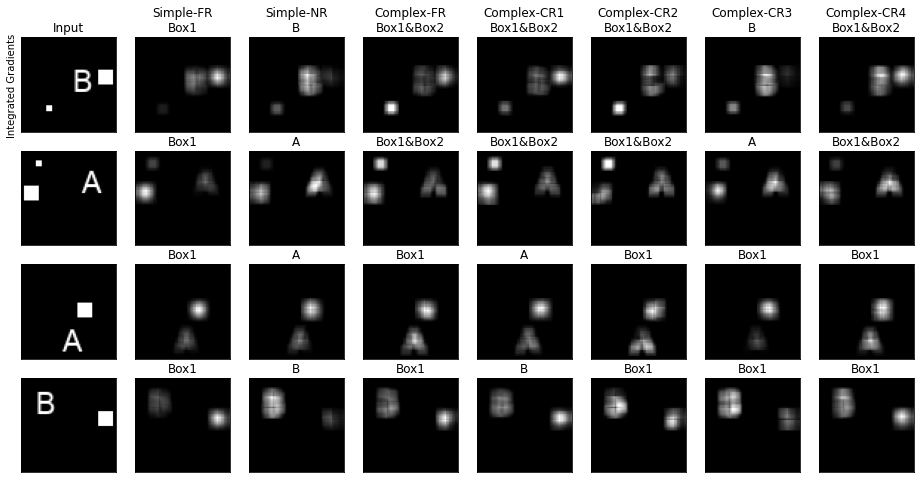

In [7]:
# Change the third argument of the function below to plot different methods
plot_id_test(dd, methods, 7, preprocess=True)